<a href="https://colab.research.google.com/github/MarkoArsenovic/PPPO2021/blob/main/Vezbe04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Vežbe 04** Binarna obrada fotografije I

## Sadržaj

1. Uvod
2. Morfološki operatori
3. Otkrivanje rupe u ogradi lanca
4. Izračunavanje Ojlerovog broja, ekscentričnosti i centra mase pomoću mahotas i scikit-image modula
5. Binarni filteri iz *mahotas* modula
6. Binarni filteri iz *SimpleITK* modula
7. Dilatacija rekonstrukcijom pomoću *scikit-image*




### Uvod

Binarne fotografije su fotografije čiji pikseli imaju samo dve moguće vrednosti intenziteta. Obično su prikazani kao crno-beli. Numerički, dve vrednosti su često 0 za crnu, a 1 ili 255 za belu.

Binarne fotografije se često proizvode graničnim vrednostima nijansi sive ili fotografije u boji kako bi se objekt na slici odvojio od pozadine. Boja predmeta (obično bela) naziva se bojom u prvom planu. Ostatak (obično crni) naziva se bojom pozadine.
Međutim, u zavisnosti od slike koju treba ograničiti, ovaj polaritet može biti obrnut, u tom slučaju se objekat prikazuje sa 0, a pozadina sa ne-nula vrednošću.

Morfološka obrada fotografije odnosi se na primenu skupa nelinearnih operacija koje su povezane sa oblikom (odnosno morfologijom) karakteristika fotografije. Ove operacije su posebno pogodne za obradu binarnih fotografija (gde su pikseli predstavljeni kao 0 ili 1 i, po dogovoru, prednji plan objekta = 1 ili beli, a pozadina = 0 ili crni), jer ne zavise od tačne numeričke vrednosti piksela; nego zavise samo od toga kako su vrednosti piksela relativno poređane - iako se ove operacije mogu proširiti i na sive fotografije.

Na ovim vežbama predstavićemo obradu binarnih fotografija sa morfološkim operacijama, mada će se, zbog kompletnosti, takođe prikazati nekoliko morfoloških operacija u sivim skalama. 
U morfološkim operacijama za strukturiranje ulazne fotografije koristi se element za strukturiranje (mala šablonska fotografija). Strukturni element (SE) se postavlja na sva moguća mesta na ulaznoj fotografiji, a zatim algoritam koristi operater skupa da bi ga uporedio sa susedstvom odgovarajućih piksela. Morfološke operacije testiraju da li se SE uklapa u odgovarajuće susedstvo, da li ga pogađa ili preseca.


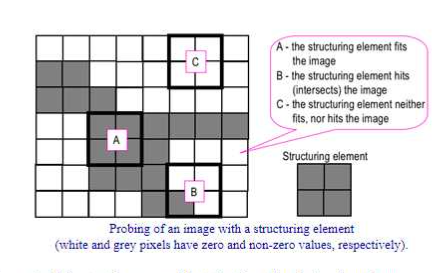

Učitavanje dataseta potrebnog za ove vežbe
- učitati images.zip

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn" -O images.zip && rm -rf /tmp/cookies.txt

--2021-03-22 19:31:47--  https://docs.google.com/uc?export=download&confirm=&id=11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn
Resolving docs.google.com (docs.google.com)... 108.177.97.113, 108.177.97.138, 108.177.97.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/8kqvoakovgb47n6gu59vlm0d6iinhbae/4mlts1cjr9bc86jgl4htn7jqiu51to0u/1616441475000/07050430151874469418/16274641606615263249Z/11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn?e=download [following]
--2021-03-22 19:31:48--  https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/8kqvoakovgb47n6gu59vlm0d6iinhbae/4mlts1cjr9bc86jgl4htn7jqiu51to0u/1616441475000/07050430151874469418/16274641606615263249Z/11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn?e=download
Resolving doc-0s-9k-docs.googleusercontent.com (doc-0s-9k-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to 

Unzip dataseta

In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
 extracting: images/blackhole.png    
  inflating: images/blackhole_out.png  
  inflating: images/blob_log_out.png  
  inflating: images/blob_watershed_out.png  
 extracting: images/bo.png           
 extracting: images/bo_inv_1.png     
 extracting: images/bo_inv_2.png     
  inflating: images/card.png         
  inflating: images/card_out.png     
  inflating: images/chainlink.png    
  inflating: images/circles.png      
  inflating: images/dice.png         
  inflating: images/dice_out.png     
  inflating: images/edge_skel.png    
  inflating: images/edt.png          
  inflating: images/edt_iter_erode.png  
 extracting: images/fingerprint.png  
  inflating: images/fingerprint_out.png  
 extracting: images/frame1.png       
 extracting: images/frame2.png       
  inflating: images/giraffe.png      
  inflating: images/grad_3d.png      
  inflating: images/hmt.png          
  inflating: images/hm_out_1.png     
  inflating: images/hm_out_2.

### Morpholocial Operators // Morfološki operatori

Dilatacija i erozija su dva osnovna morfološka operatora. 

Erozija uklanja sloj piksela sa granica prednjih (belih) objekata i na taj način smanjuje prvi plan na binarnoj fotografiji. Sitni detalji se uklanjaju, a veličina područja od interesa smanjuje se erozijom na binarnoj slici. Dilatacija dodaje sloj piksela na granice objekata u prvom planu, čime se proširuje u prvi plan. Rupe sadržane unutar jednog predmeta u prvom planu i praznine između objekata u prvom planu (i granica) su smanjene.

Mnogo morfoloških operacija može se dobiti kao kombinacija erozije, širenja i osnovnih skupovnih operacija (npr. komplement). Morfološko otvaranje, zatvaranje i hitor-mis transformacija su najpopularniji. 

Otvaranje je idempotentna operacija (sprovedena sa dilatacijom praćenom erozijom) koja može odvojiti objekte u prvom planu povezane tankim slojem piksela, zadržavajući veličinu preživelih objekata jednakom. 

Slično tome, zatvaranje (dvostruki operator otvaranja: sprovedeno sa erozijom praćenom dilatacijom) je još jedna idempotentna operacija koja može popuniti rupe u prednjem planu, a zadržati iste veličine regiona. 

Sledeća fotografija prikazuje kako su definisani osnovni i nekoliko složenih morfoloških operatora pomoću operatora iz teorije skupova:

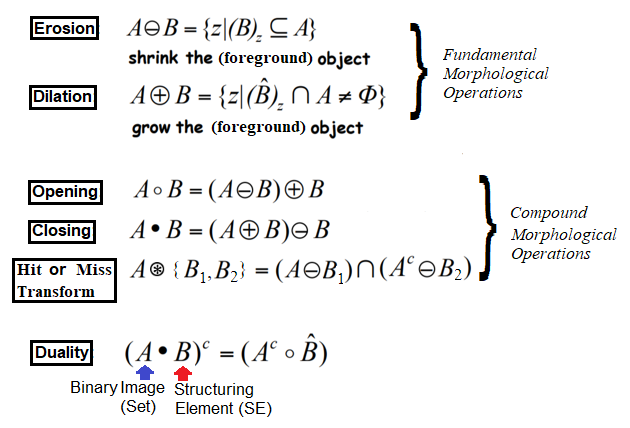

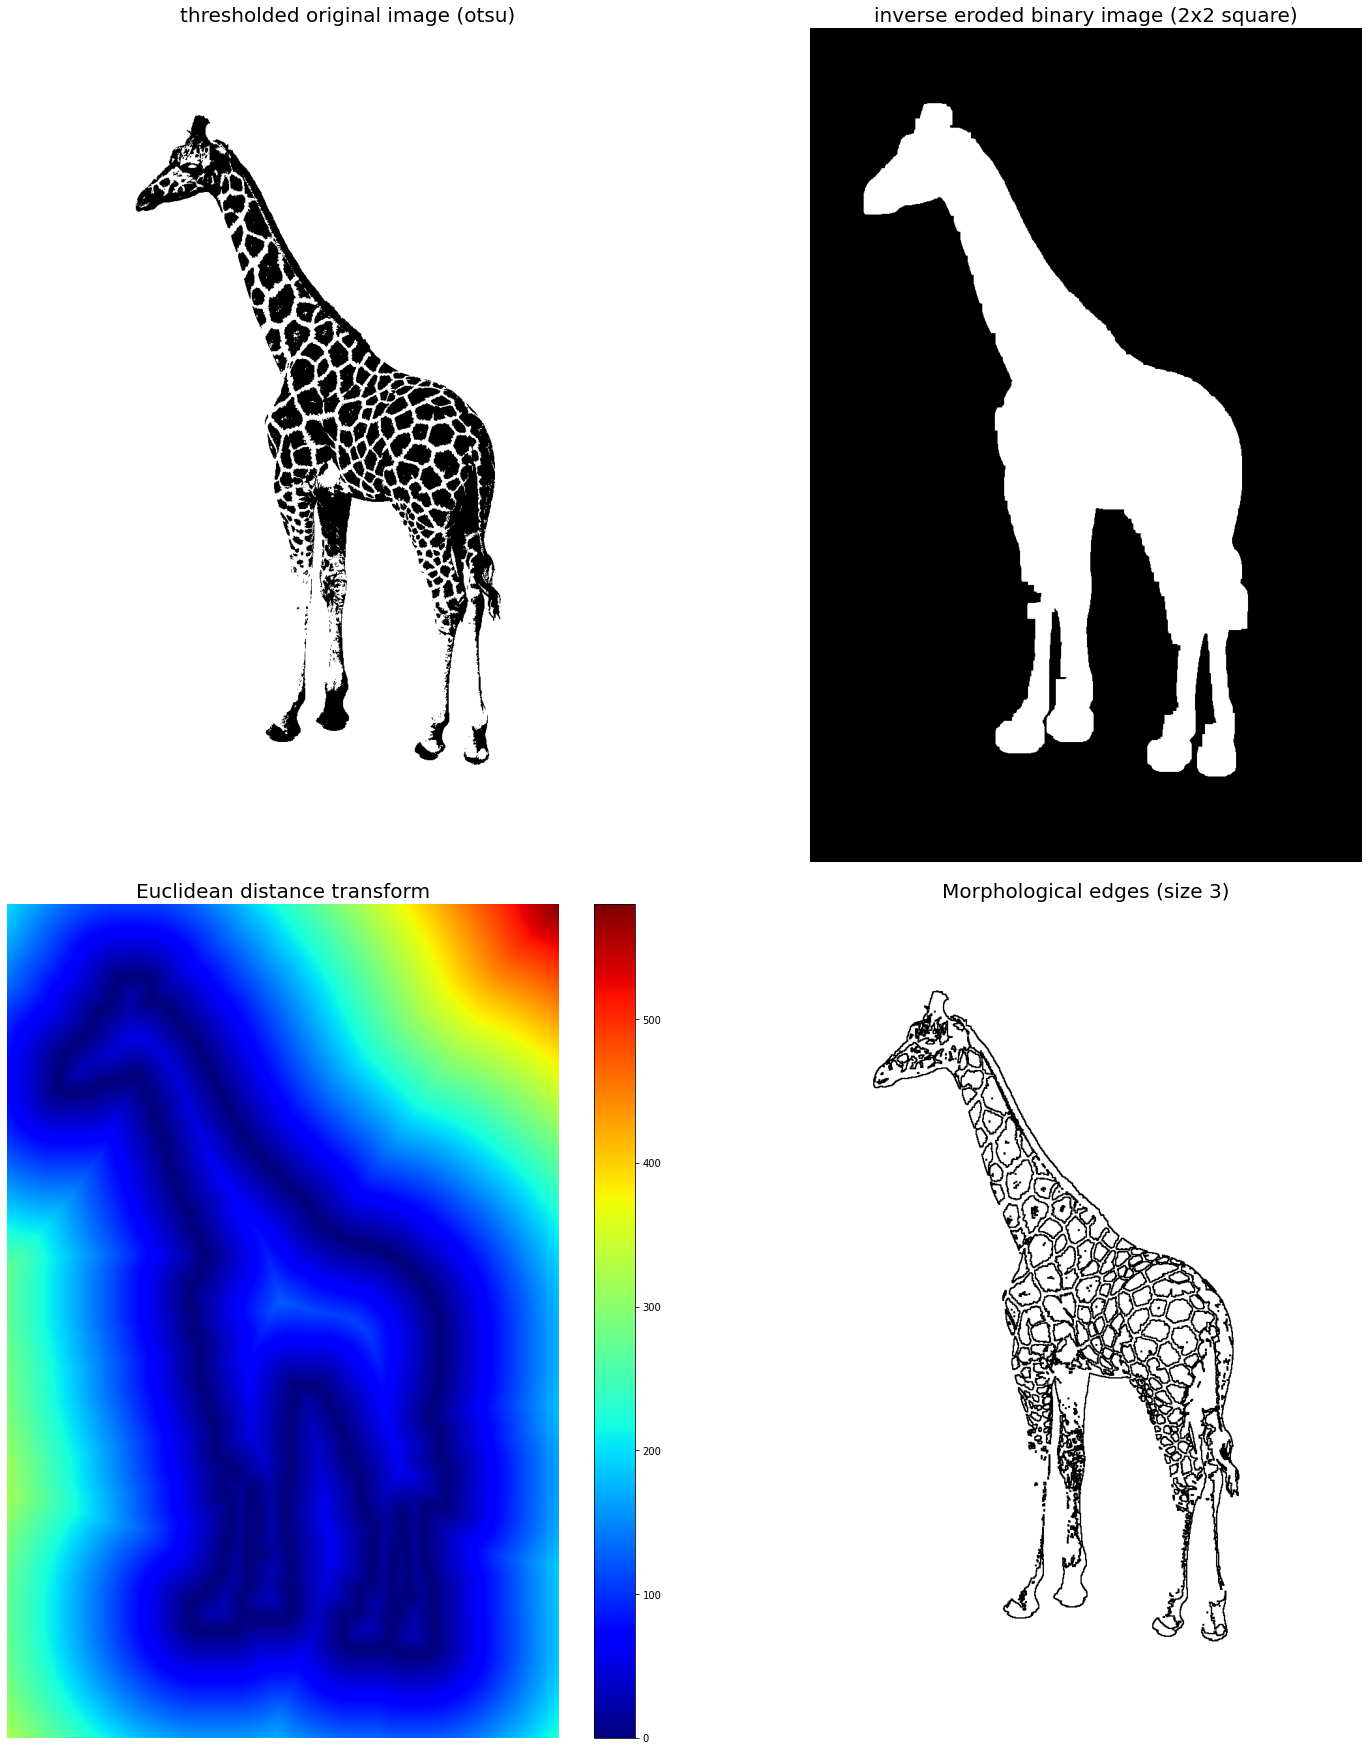

In [ ]:
%matplotlib inline

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes, morphological_gradient, distance_transform_edt
import numpy as np
import matplotlib.pylab as plt

"""
Učitajte ulaznu fotografiju žirafe, zatim je pretvorite u binarnu sliku
praga. Izračunajte optimalni prag pomoću Otsu-ovog algoritma, a zatim
promenite piksele sa vrednostima iznad praga u belo i crno:
"""
im = rgb2gray(imread('images/giraffe.png'))
thres = threshold_otsu(im)
im = (im > thres).astype(np.uint8)

"""
Pomoću 2x2 kvadratnog elementa za strukturiranje (SE/kernel) 
kreirajte efekat nagrizanja fotografije i obrnite fotografiju
"""
eroded = binary_erosion(im, structure=np.ones((2,2)), iterations=20)[20:,20:]
eroded = 1 - eroded

"""
Sada proširite erodiranu(negiženu) fotografiju 
sa 11x11 kvadratnih (SE/kernel) elemenata i izračunajte
granice fotografije uzimanjem razlike između proširene i erodirane fotografije. 
Koristite (euklidsku) transformaciju rastojanja na obrnutoj
graničnoj fotografiji:
"""
dilated = binary_dilation(eroded, structure=np.ones((11,11)))
"""
Izračunati morfološki_gradient binarne fotografije. 
Obrnite izlaz da biste dobili ivice:
"""
edges = 1 - morphological_gradient(im, size=3) #dilated5.astype(np.int) - eroded5.astype(np.int)
boundary = np.clip(dilated.astype(np.int) - eroded.astype(np.int), 0, 1)
dt = distance_transform_edt(np.logical_not(boundary))

plt.figure(figsize=(20,25))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('thresholded original image (otsu)', size=20)
plt.subplot(222), plt.imshow(eroded), plt.axis('off'), plt.title('inverse eroded binary image (2x2 square)', size=20)
plt.subplot(223), plt.imshow(dt, cmap='jet'), plt.axis('off'), plt.title('Euclidean distance transform', size=20), plt.colorbar()
plt.subplot(224), plt.imshow(edges), plt.axis('off'), plt.title('Morphological edges (size 3)', size=20)
plt.show()

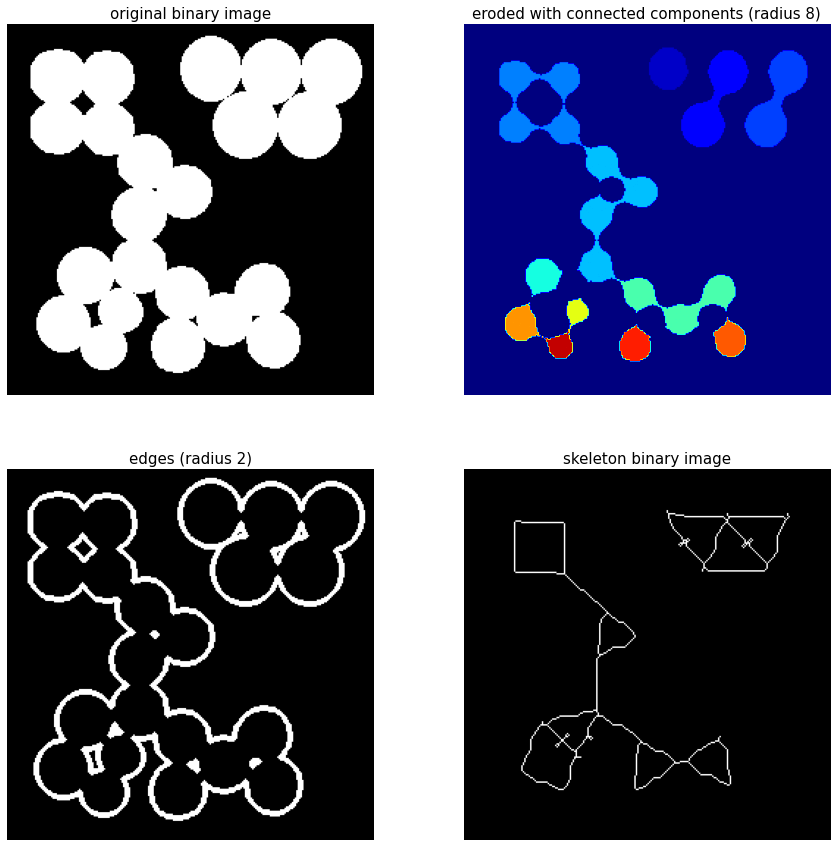

In [ ]:
from skimage import morphology as morph
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

"""
Učitajte fotografiju circles.png i pretvorite je u binarnu fotografiju 
(odaberite prag vrednosti 0):
"""
im = rgb2gray(imread('images/circles.png'))
im = (im > 0).astype(np.uint8)


"""
'Isperite' (erodirajte) binarne fotografije 
pomoću diskova SE različitih veličina. 
Zatim, označite povezane komponente ispranih (erodiranih) fotografija 
sa poveznim faktorom vrednosti 1:
"""
disk2 = morph.disk(radius=2)
disk8 = morph.disk(radius=8)

eroded2 = morph.binary_erosion(im, selem=disk2)
eroded8 = morph.binary_erosion(im, selem=disk8)
labeled = morph.label(eroded8, connectivity=1)

"""
Proširite fotografiju i izračunajte ivice unutar fotografije,
izračunajte morphological_gradient uzimanjem razlike između
proširene i isprane (erodirane) fotografije:
"""
dilated2 = morph.binary_dilation(im, selem=disk2)
edges = dilated2.astype(np.int) - eroded2.astype(np.int)

"""
Skeletirajte binarnu fotografiju
"""
skeleton = morph.skeletonize(im)

"""
Prikažite rezultujuće fotografije
"""
plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('original binary image', size=15)
plt.subplot(222), plt.imshow(labeled, cmap='jet'), plt.axis('off'), plt.title('eroded with connected components (radius 8)', size=15)
plt.subplot(223), plt.imshow(edges), plt.axis('off'), plt.title('edges (radius 2)', size=15)
plt.subplot(224), plt.imshow(skeleton), plt.axis('off'), plt.title('skeleton binary image', size=15)
plt.show()

### Chain link fence hole detection // Otkrivanje rupe u ogradi lanca

Binarna erozija je matematička morfološka operacija koja se koristi za obradu slika. Elementi koji nisu nula smatraju se tačnim. Ako nije naveden nijedan element za strukturiranje, element se generiše sa kvadratnom povezanošću jednakom jedinici.

Potrebno je otkriti rupe u ogradi lanca i pronaći položaje rupa (postoje dva) na sledećoj fotografiji lanca pomoću morfoloških operatora.

Savet: prvo je pretvorite u binarnu fotografiju.

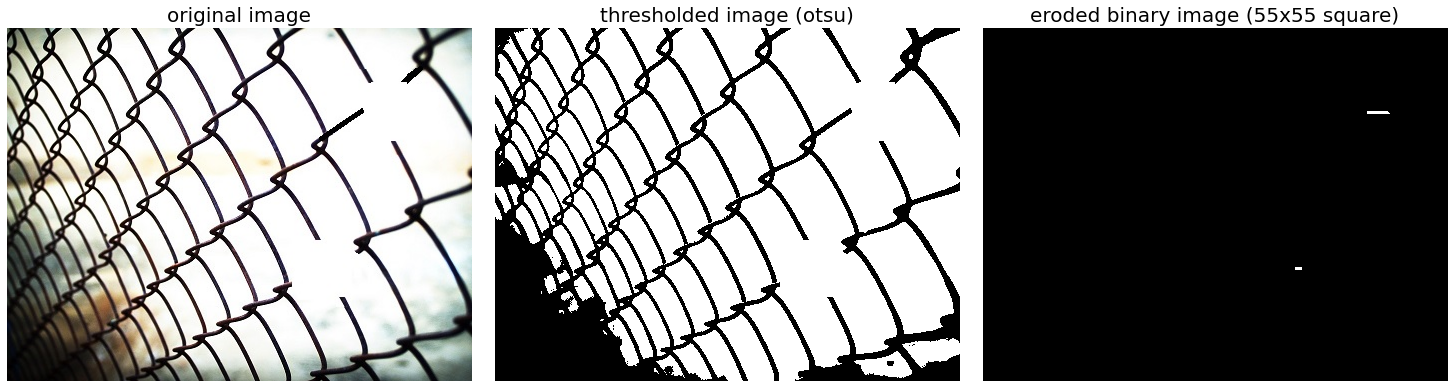

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, square
import numpy as np
import matplotlib.pylab as plt

orig = imread('images/chainlink.png')
im = rgb2gray(orig)
thres = threshold_otsu(im)
im = (im > thres).astype(np.uint8)

eroded = binary_erosion(im, square(55))

plt.figure(figsize=(20,7))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(131), plt.imshow(orig), plt.axis('off'), plt.title('original image', size=20)
plt.subplot(132), plt.imshow(im), plt.axis('off'), plt.title('thresholded image (otsu)', size=20)
plt.subplot(133), plt.imshow(eroded), plt.axis('off'), plt.title('eroded binary image (55x55 square)', size=20)
plt.show()

### Computing the Euler number, ecentricity, center of mass with mahotas and scikit-image// Izračunavanje Ojlerovog broja, ekscentričnosti i centra mase pomoću *mahotas* i *scikit-image* modula

Ojlerovim brojem meri se topologija binarne fotografije.
Definisan je kao razlika ukupnog broja objekata na fotografiji i broja rupa prisutnih u tim objektima. 

Ekscentričnost meri najkraću dužinu putanje od date koordinate do bilo koje druge koordinate povezanog grafa. Definiše se kroz grafikon susedstva i datu metriku.

Centar mase je položaj definisan u odnosu na objekat ili sistem objekata. To je prosečan položaj svih delova sistema, otežan prema njihovoj masi. Za jednostavne krute predmete ujednačene gustine, centar mase se nalazi na težištu.

Za naredne primere koristićemo *mahotas* i *scikit-image* biblioteke.

- Funkcija *euler()*, iz biblioteke *mahotas*, koristi se za izračunavanje Ojlerovog broja (ili karakteristika) ulazne binarne fotografije. Podrazumevano koristi 8 veza.

- Funkcija *flood_fill()*, iz *skimage.morphology* modula, koristi se za izvršavanje popunjavanja poplave na binarnoj fotografiji crne rupe, počevši od određene tačke semena (200.400) na tamnom području unutar crne rupe (prosleđena kao drugi argument funkciji).
Pronađene su povezane tačke jednake vrednosti početnog piksela (0 ili crno), a zatim postavljene na *new_value* (1 ili belo), ​​što je treći ulazni parametar funkcije.

- Funkcija *diameter_closing()*, iz *skimage.morphology modula*, koristi se za uklanjanje svih rupa sa fotografije crne rupe sa maksimalnim produžetkom (bočna strana graničnog okvira koji zatvara rupu) manjim od parametra *diameter_threshold* (to jest 100). Ovaj operater poznat je i pod nazivom zatvaranje granične kutije.

In [ ]:
!pip install mahotas

Eccentricity = 0.5449847073316407


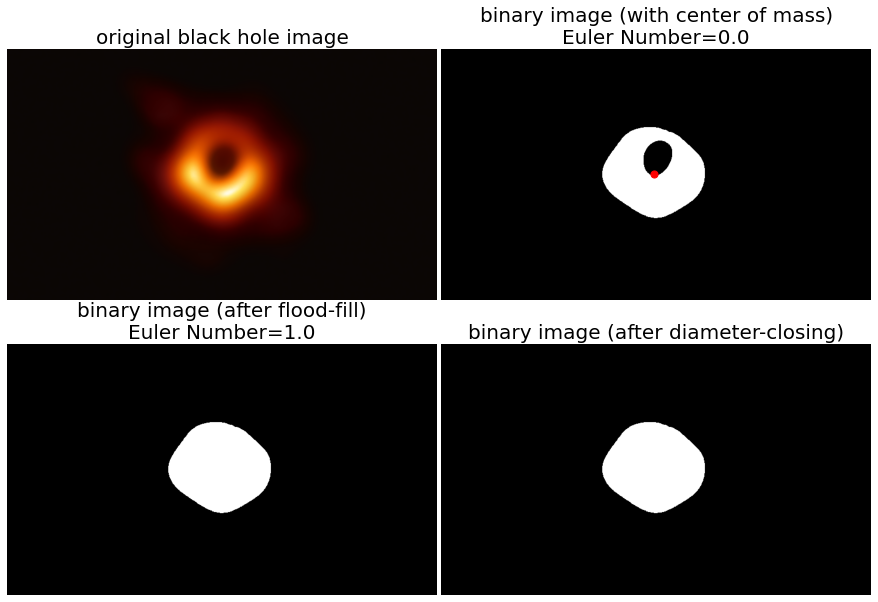

In [ ]:
import mahotas as mh
import matplotlib.pylab as plt
import numpy as np
from skimage.morphology import flood_fill, diameter_closing

"""
Učitajte NASA-inu fotografiju crne rupe i pretvorite je u binarnu fotografiju
koristeći manualni prag (t = 60). 
Izračunajte Eulerov broj za binarnu fotografiju:
"""
blackhole = mh.imread('images/blackhole.png')
blackhole_gray = mh.colors.rgb2grey(blackhole).astype(np.uint8)
t = 60 #mahotas.rc(blackhole_gray)   
bin_blackhole = (blackhole_gray > t).astype(np.uint8)

"""
Izračunajte centar mase (center_of_mass) i ekscentričnost binarne fotografije:
"""
cms = mh.center_of_mass(bin_blackhole)
print('Eccentricity =', mh.features.eccentricity(bin_blackhole))
# 0.5449847073316407
"""
Popunite crnu rupu koristeći flood_fill (počevši od semena unutar crne rupe)
ili diameter_closing (uklanjanje svih rupa na površini manjoj ili jednakoj 100):
"""
plt.figure(figsize=(12,8))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.05)
plt.subplot(221), plt.imshow(blackhole), plt.axis('off'), plt.title('original black hole image', size=20)
#bin_blackhole = mahotas.border(bin_blackhole)
plt.subplot(222), plt.imshow(bin_blackhole), plt.axis('off'), plt.title('binary image (with center of mass)\nEuler Number={}'.format(mh.euler(bin_blackhole)), size=20)
plt.scatter(cms[1], cms[0], color='red', s=50)
bin_blackhole2 = flood_fill(bin_blackhole, (200,400), 1)
plt.subplot(223), plt.imshow(bin_blackhole2), plt.axis('off'), plt.title('binary image (after flood-fill)\nEuler Number={}'.format(mh.euler(bin_blackhole2)), size=20)
plt.subplot(224), plt.imshow(diameter_closing(bin_blackhole, 100, connectivity=2)), plt.axis('off'), plt.title('binary image (after diameter-closing)', size=20)
plt.show()

# Za prvu binarnu fotografiju, Ojlerov broj je 0 = 1 - 1 (ima jedan objekat koji sadrži jednu rupu). 
# Za drugu binarnu sliku, Ojlerov broj je 1 - 0 = 1 (pošto pojedinačni objekat koji sadrži nema rupu u sebi).

### Binary Image Filters with mahotas // Binarni filteri iz *mahotas* modula

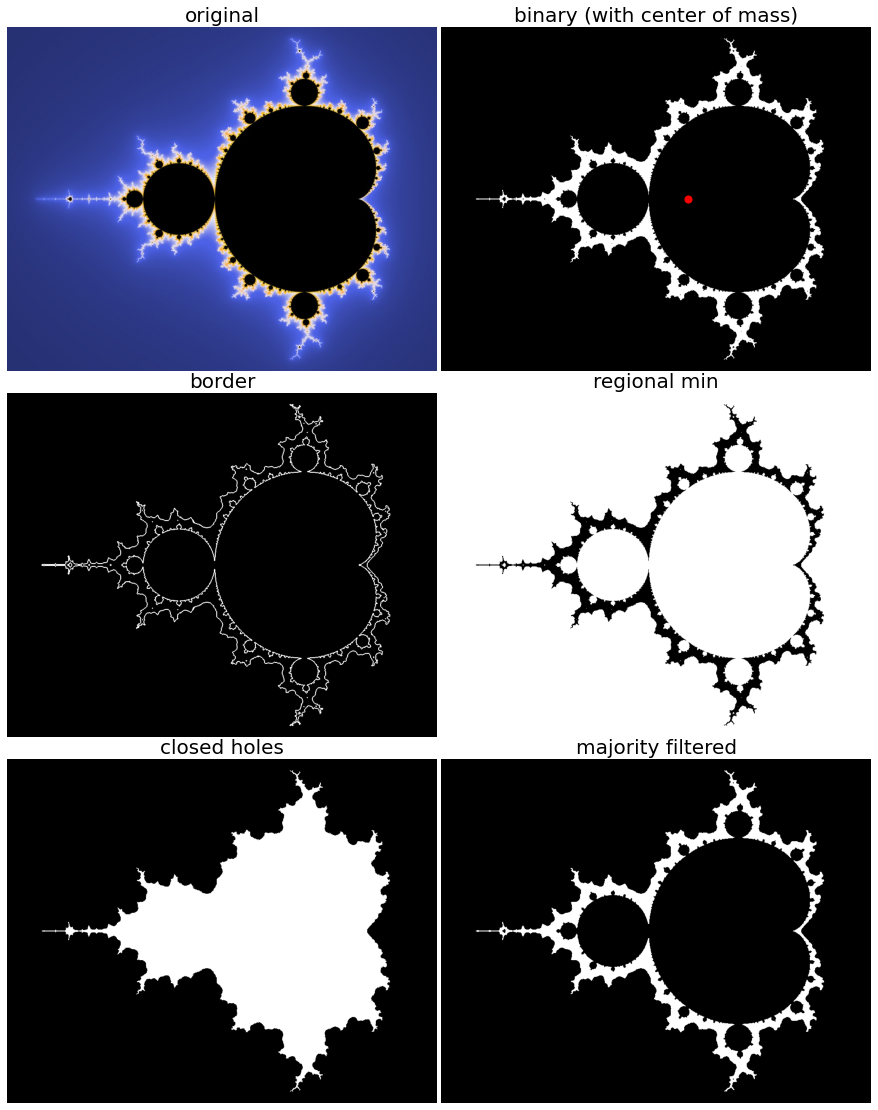

-37.0
0.3972466632451082


In [ ]:
import mahotas as mh
import matplotlib.pylab as plt
import numpy as np
"""
Učitajte fotografiju mandelbrot u boji, pretvorite je u sive tonove, 
a zatim koristite otsu prag da biste je pretvorili u binarnu fotografiju:
"""
fractal = mh.imread('images/mandelbrot.png')
fractal_gray = mh.colors.rgb2grey(fractal).astype(np.uint8)
t = mh.otsu(fractal_gray) #
#print(t)
bin_fractal = (fractal_gray > t).astype(np.uint8)
#bin_fractal = mahotas.bwperim(bin_fractal) mahotas.thin(bin_fractal)
cms = mh.center_of_mass(bin_fractal)
plt.figure(figsize=(12,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.05)
plt.subplot(321), plt.imshow(fractal), plt.axis('off'), plt.title('original', size=20)
plt.subplot(322), plt.imshow(bin_fractal), plt.axis('off'), plt.title('binary (with center of mass)', size=20)
plt.scatter(cms[1], cms[0], color='red', s=50)
"""
izračunajte granicu između belog i crnog piksela
"""
plt.subplot(323), plt.imshow(mh.border(bin_fractal, 0, 1)), plt.axis('off'), plt.title('border', size=20)
"""
Izračunajte regionalni minimum 
(sa regionom definisanim kao SE jezgra 3x3 oko svakog piksela i uzimajući u obzir ceo objekat) 
"""
plt.subplot(324), plt.imshow(mh.regmin(bin_fractal)), plt.axis('off'), plt.title('regional min', size=20)
"""
Zatvorite rupe na fotografiji pomoću SE jezgra kao diska sa radijusom 3
"""
plt.subplot(325), plt.imshow(mh.close_holes(bin_fractal, mh.disk(3))), plt.axis('off'), plt.title('closed holes', size=20)
"""
Primenite majority_filter nad binarnom fotografijom
"""
plt.subplot(326), plt.imshow(mh.majority_filter(bin_fractal)), plt.axis('off'), plt.title('majority filtered', size=20)
plt.show()
print(mh.euler(bin_fractal))
print(mh.features.eccentricity(bin_fractal))

### Binary Filters with SimpleITK // Binarni filteri iz *SimpleITK* modula

- Konstruktor *BinaryMedianImageFilter()* koristi se za instanciju binarnog medijanskog filtera (za odbacivanje fotografije supernove), a radijus SE diska za ovaj morfološki filter postavljen je pomoću metode *SetRadius()*. Filter se primenjuje na ulaznu binarnu fotografiju metodom *Execute()*, kao i za ostale *SimpleITK* filtere.

In [ ]:
!pip install itk

     |████████████████████████████████| 14.4MB 324kB/s 
     |████████████████████████████████| 14.0MB 336kB/s 
     |████████████████████████████████| 68.0MB 54kB/s 
     |████████████████████████████████| 50.1MB 182kB/s 
     |████████████████████████████████| 10.3MB 14.4MB/s 
     |████████████████████████████████| 36.3MB 2.7MB/s 


In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 82kB/s 


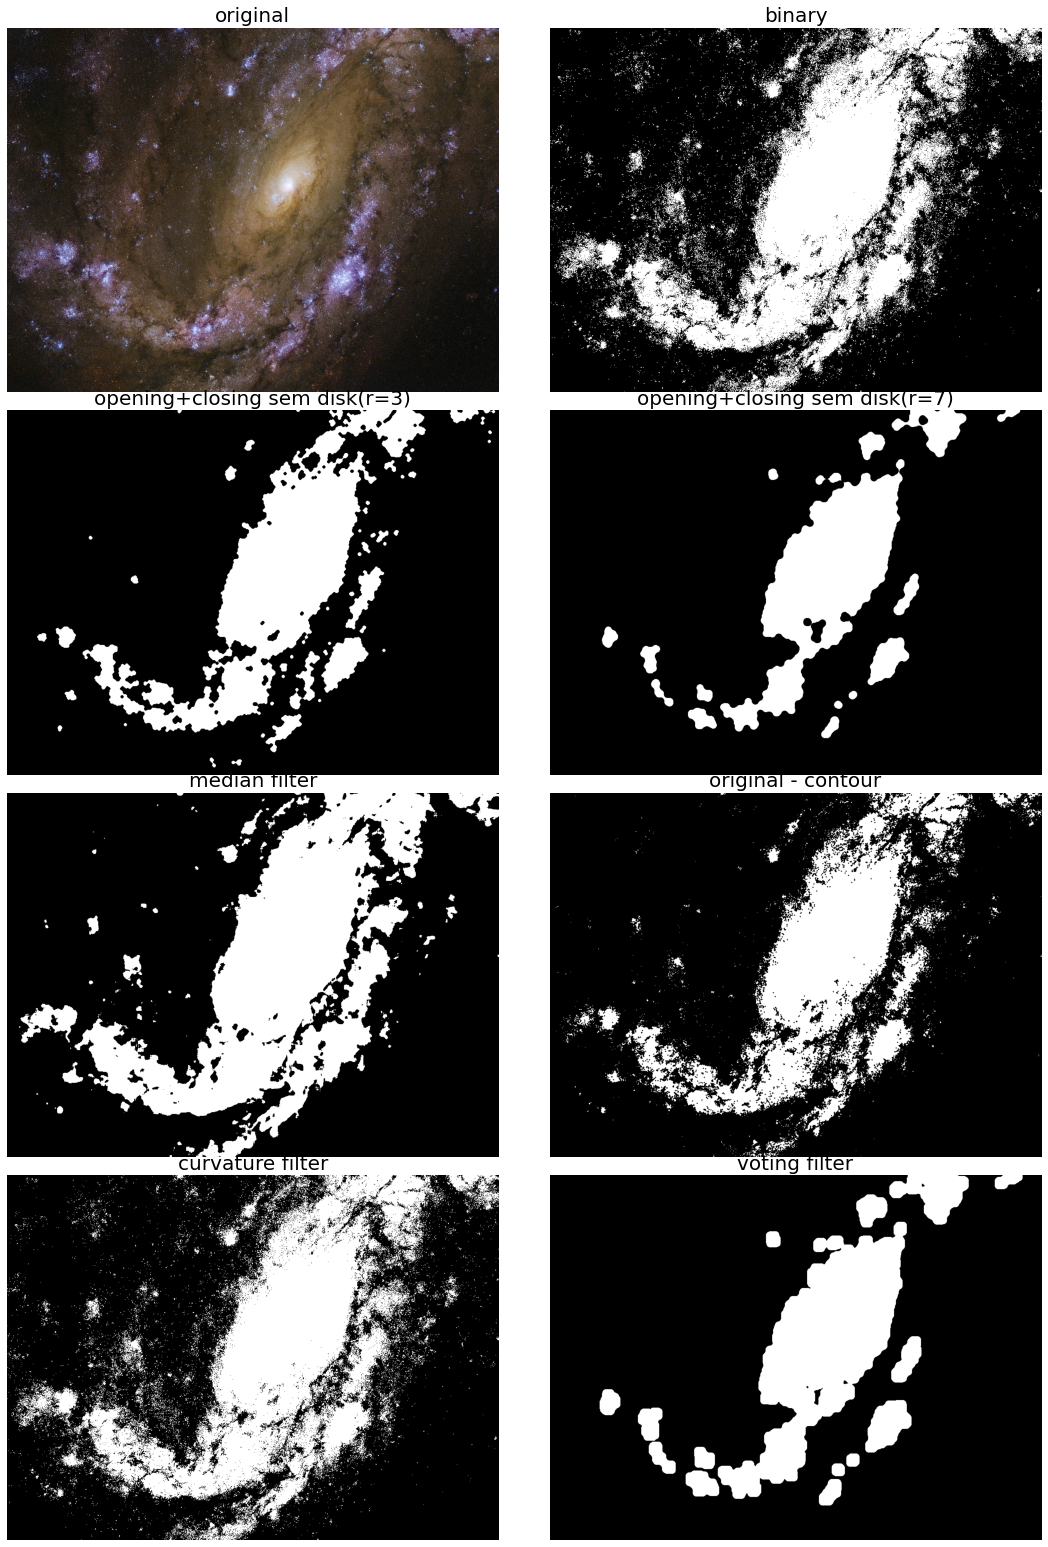

In [ ]:
import itk
import SimpleITK as sitk
import matplotlib.pylab as plt
import numpy as np

"""
Učitajte NASA-inu fotografiju supernova.png i konvertujte
je u binarnu. Negirajte binarnu fotografiju:
"""
supernova = itk.imread('images/supernova.png') 
supernova_gray = itk.RGBToLuminanceImageFilter.New(supernova)
supernova_gray = sitk.GetImageFromArray(itk.GetArrayFromImage(supernova_gray))
supernova_gray = sitk.Cast(supernova_gray, sitk.sitkFloat32)
supernova_bin = sitk.BinaryNotImageFilter().Execute(sitk.OtsuThresholdImageFilter().Execute(supernova_gray ))


"""
Instancirajte objekte filtra SimpleITK koji odgovaraju otvaranju i
zatvaranju morfoloških filtera. 
Postavite SE kao disk radijusa 3. 
Prvo primenite otvorni filter 
praćen zatvaračkim filterom do binarne fotografije supernove:
"""
open_f = sitk.BinaryMorphologicalOpeningImageFilter()
close_f = sitk.BinaryMorphologicalClosingImageFilter()
open_f.SetKernelRadius(3)
close_f.SetKernelRadius(3)
supernova_bin1 = close_f.Execute(open_f.Execute(supernova_bin))
"""
Primenite filter za otvaranje, a zatim filter za zatvaranje, 
ponovo na ulaznu binarnu fotografiju, 
ovog puta sa SE u obliku kruga poluprečnika vrednosti 7:
"""
open_f.SetKernelRadius(7)
close_f.SetKernelRadius(7)
supernova_bin2 = close_f.Execute(open_f.Execute(supernova_bin))

"""
Nad ulaznom binarnom fotografijom
primeniti srednji filter sa SEM-om kao diskom radijusa 3:
"""
med_f = sitk.BinaryMedianImageFilter()
med_f.SetRadius(3)
supernova_bin3 = med_f.Execute(supernova_bin)

"""
Primenite BinaryMinMaxCurvatureFlowImageFilter() na binarnu fotografiju
koristeći sledeći segment koda (sa radijusom matrice 2 i pragom
vrednosti 60):
"""
curv_f = sitk.BinaryMinMaxCurvatureFlowImageFilter() 
curv_f.SetStencilRadius(2)
curv_f.SetThreshold(60)
supernova_bin4 = curv_f.Execute(sitk.Cast(supernova_bin, sitk.sitkFloat32))

"""
Primenite BinaryContourImageFilter() na fotografiju nakon instanciranja 
odgovarajućeg objekta:
"""
cont_f = sitk.BinaryContourImageFilter()
supernova_bin5 = cont_f.Execute(supernova_bin)

"""
Instancirajte VotingBinaryImageFilter() nad binarnom fotografijom
"""
vote_f = sitk.VotingBinaryImageFilter()
vote_f.SetRadius(5)
supernova_bin6 = vote_f.Execute(sitk.Cast(supernova_bin2, sitk.sitkInt32))

plt.figure(figsize=(15,21))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.05)
plt.subplot(421), plt.imshow(itk.GetArrayFromImage(supernova)), plt.axis('off'), plt.title('original', size=20)
plt.subplot(422), plt.imshow(sitk.GetArrayFromImage(supernova_bin)), plt.axis('off'), plt.title('binary', size=20)
plt.subplot(423), plt.imshow(sitk.GetArrayFromImage(supernova_bin1)), plt.axis('off'), plt.title('opening+closing sem disk(r=3)', size=20)
plt.subplot(424), plt.imshow(sitk.GetArrayFromImage(supernova_bin2)), plt.axis('off'), plt.title('opening+closing sem disk(r=7)', size=20)
plt.subplot(425), plt.imshow(sitk.GetArrayFromImage(supernova_bin3)), plt.axis('off'), plt.title('median filter', size=20)
plt.subplot(426), plt.imshow(sitk.GetArrayFromImage(supernova_bin - supernova_bin5)), plt.axis('off'), plt.title('original - contour', size=20)
plt.subplot(427), plt.imshow(sitk.GetArrayFromImage(supernova_bin4)), plt.axis('off'), plt.title('curvature filter', size=20)
plt.subplot(428), plt.imshow(sitk.GetArrayFromImage(supernova_bin6)), plt.axis('off'), plt.title('voting filter', size=20)
plt.show()

### Dilation by Reconstruction with scikit-image // Dilatacija rekonstrukcijom pomoću *scikit-image*


Dilatacija (proširenje) je jedna od osnovnih operacija u matematičkoj morfologiji. Operacija dilatacije obično koristi strukturni element za sondiranje i proširivanje oblika sadržanih na ulaznoj slici.

Dilatacija operacijom rekonstrukcije koristi fotografiju semena i maske. Početna fotografija navodi vrednosti sa kojima treba započeti (koja se iterativno širi koristeći SE za širenje), dok fotografija maske (originalna fotografija je korišćena kao fotografija maske) ​​navodi maksimalnu vrednost dozvoljenu za svaki piksel. Fotografija maske ograničava širenje vrednosti u prvi plan.


- Funkcija *reconstruction()*, iz skimage.morphology modula, koristi se za sprovođenje dilatacije rekonstrukcijom. 

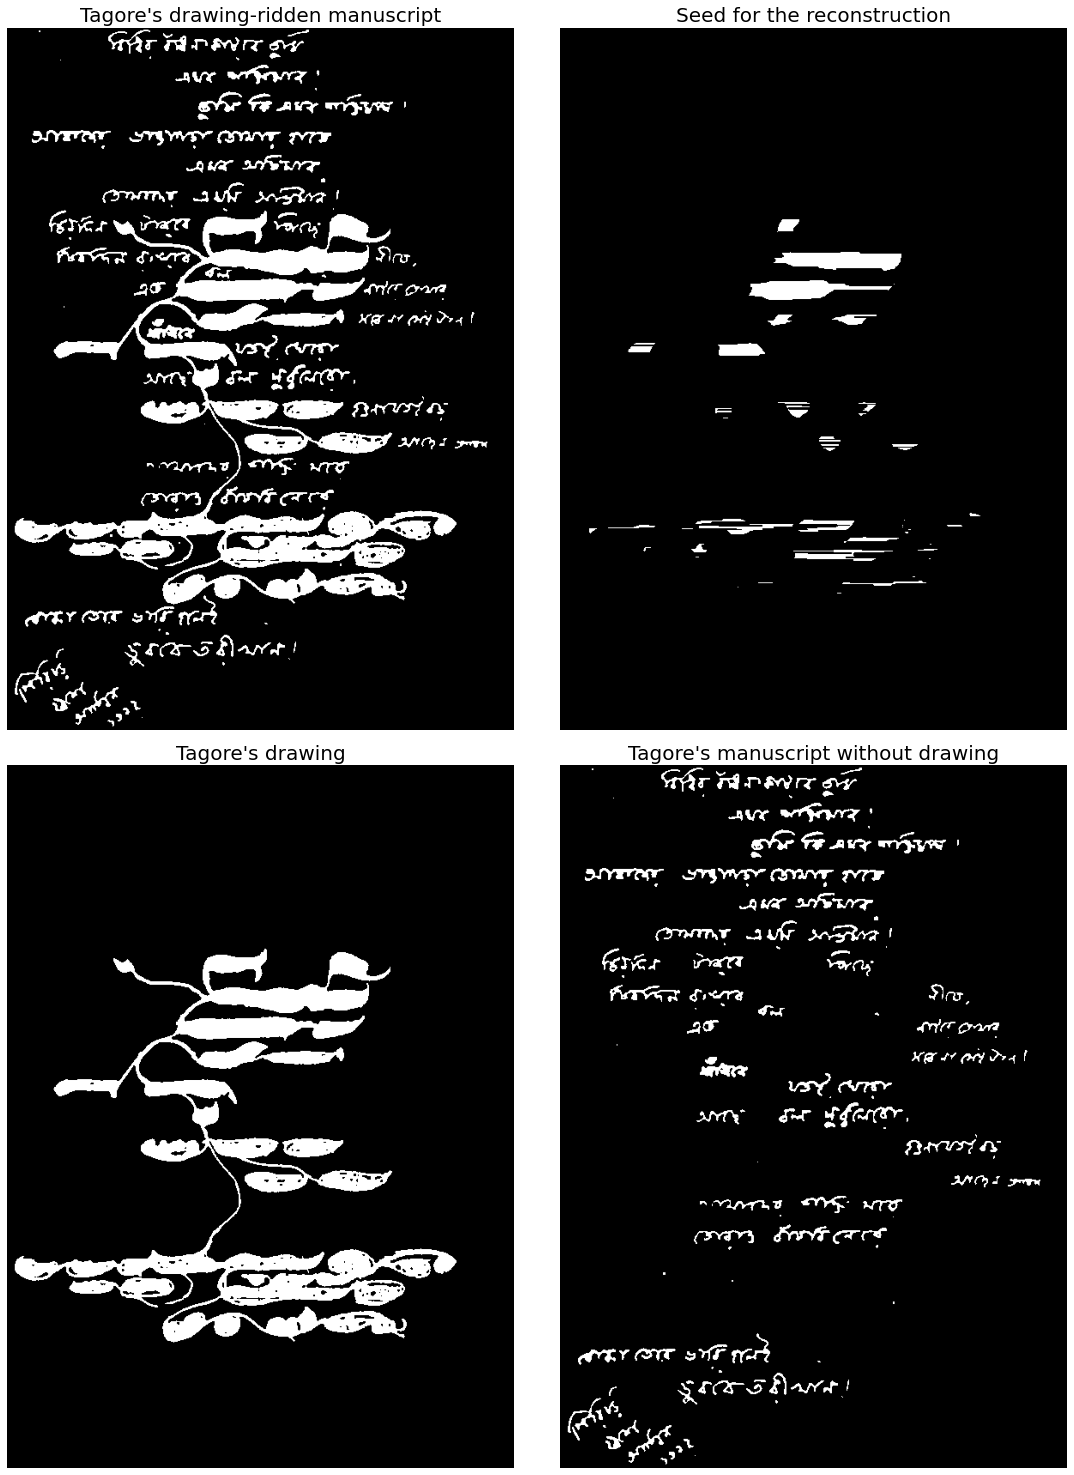

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import reconstruction
from skimage.morphology import binary_erosion, rectangle
import matplotlib.pylab as plt
import numpy as np

"""

Pročitajte ulaznu fotografiju (Tagore-ov bengalski manuskript jedne od njegovih
pesama u sopstvenom rukopisu) i pretvoriti ga u binarnu sliku sa
pragom praćenim binarnom inverzijom 
(želite da slova alfabeta budu objekti u prvom planu, odnosno beli):
"""
img = rgb2gray(imread('images/tagore_manuscript.png'))
th = 0.6 #threshold_otsu(img)
img[img <= th] = 0
img[img > th] = 1
img = 1 - img

"""
Fotografija maske potrebna za rekonstrukciju širenjem je jednostavna binarna
fotografija dobijena ranije. 
Napravite fotografiju semena (rekonstrukcija dilatacijom)
koristeći operaciju binary_erosion sa filterom vertikalne linije. 
Izvedite rekonstrukciju širenjem pomoću maske i kreiranih fotografija semena:
"""
mask = img
seed = binary_erosion(img, rectangle(1,50))
words = reconstruction(seed, mask, 'dilation')
plt.figure(figsize=(15,20))
plt.subplots_adjust(0,0,1,1,0.05,0.05)
plt.subplot(221), plt.imshow(img), plt.axis('off'), plt.title('Tagore\'s drawing-ridden manuscript', size=20)
plt.subplot(222), plt.imshow(seed), plt.axis('off'), plt.title('Seed for the reconstruction', size=20)
plt.subplot(223), plt.imshow(words), plt.axis('off'), plt.title('Tagore\'s drawing', size=20)
plt.subplot(224), plt.imshow(img-words), plt.axis('off'), plt.title('Tagore\'s manuscript without drawing', size=20)
plt.show()

## Dodatni primeri

Euler number = 314.75
Eccentricity = 0.8586700303650091


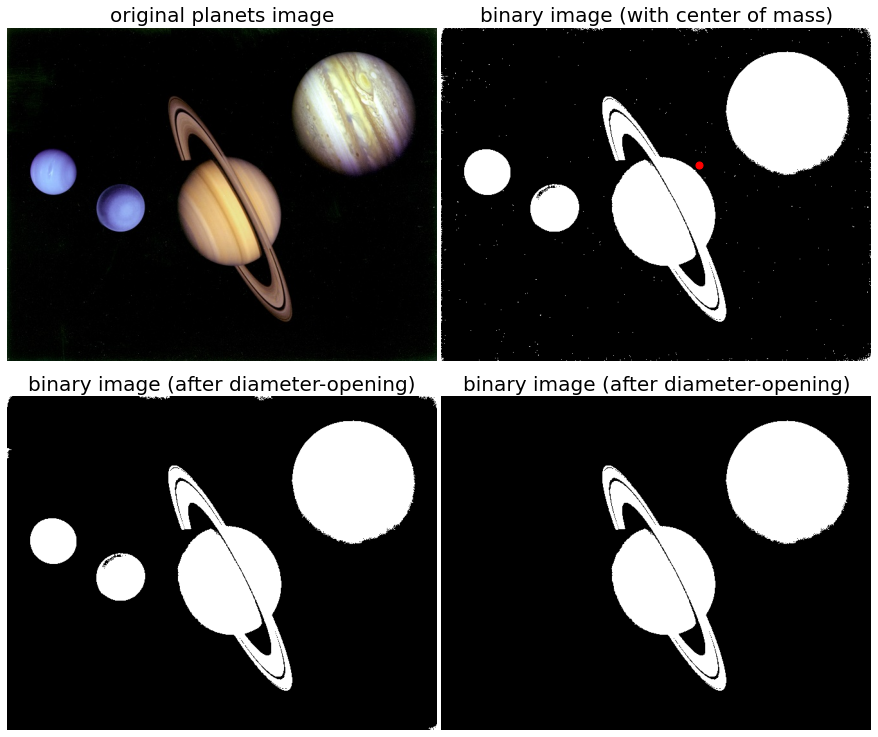

In [ ]:
import mahotas as mh
import matplotlib.pylab as plt
import numpy as np
from skimage.morphology import diameter_opening
planets = mh.imread('images/planets.png')
planets_gray = mh.colors.rgb2grey(planets).astype(np.uint8)
t = 25 #mahotas.rc(planets_gray)   
bin_planets = (planets_gray > t).astype(np.uint8)
cms = mh.center_of_mass(bin_planets)
#print(cms)
print('Euler number =', mh.euler(bin_planets))
print('Eccentricity =', mh.features.eccentricity(bin_planets))
plt.figure(figsize=(12,10))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.05)
plt.subplot(221), plt.imshow(planets), plt.axis('off'), plt.title('original planets image', size=20)
#bin_blackhole = mahotas.border(bin_blackhole)
plt.subplot(222), plt.imshow(bin_planets), plt.axis('off'), plt.title('binary image (with center of mass)', size=20)
plt.scatter(cms[1], cms[0], color='red', s=50)
plt.subplot(223), plt.imshow(diameter_opening(bin_planets, 10, connectivity=2)), plt.axis('off'), plt.title('binary image (after diameter-opening)', size=20)
plt.subplot(224), plt.imshow(diameter_opening(bin_planets, 100, connectivity=2)), plt.axis('off'), plt.title('binary image (after diameter-opening)', size=20)
plt.show()

Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


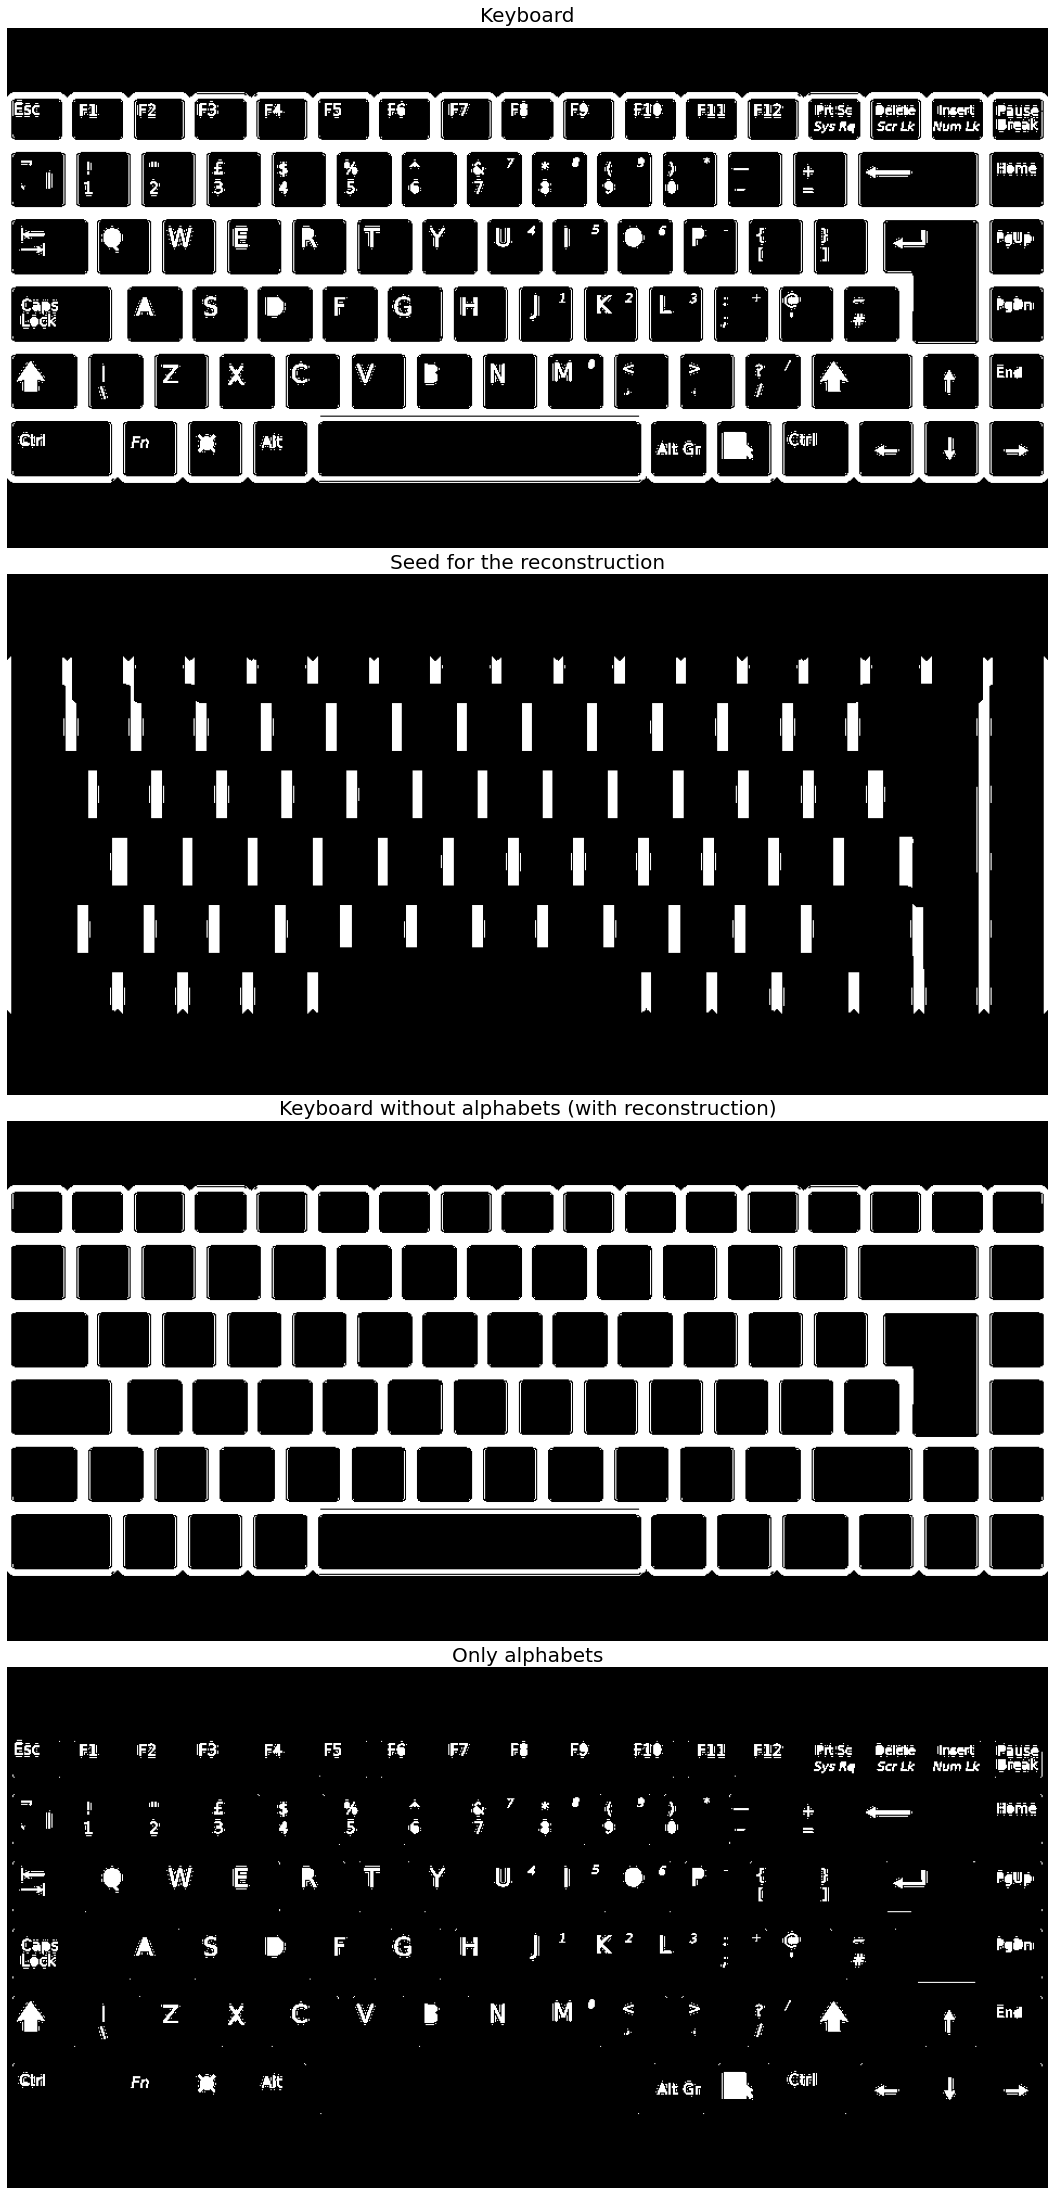

In [ ]:
% matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import reconstruction
from skimage.morphology import binary_erosion, rectangle, remove_small_objects, remove_small_holes
import matplotlib.pylab as plt
import numpy as np
img = rgb2gray(imread('images/keyboard.png'))
th = 0.18 #threshold_otsu(img)
img[img <= th] = 0
img[img > th] = 1
img = remove_small_holes(255*img.astype(np.uint8), 256)
mask = img
seed = binary_erosion(img, rectangle(30,1))
words = reconstruction(seed, mask, 'dilation')
plt.figure(figsize=(20,30))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.05,0.05)
plt.subplot(411), plt.imshow(img), plt.axis('off'), plt.title('Keyboard', size=20)
plt.subplot(412), plt.imshow(seed), plt.axis('off'), plt.title('Seed for the reconstruction', size=20)
plt.subplot(413), plt.imshow(words), plt.axis('off'), plt.title('Keyboard without alphabets (with reconstruction)', size=20)
plt.subplot(414), plt.imshow(remove_small_objects((img-words).astype(np.uint8), 20)), plt.axis('off'), plt.title('Only alphabets', size=20)
plt.show()  

## Korisni linkovi

* [Morphological](https://web.stanford.edu/class/ee368/Handouts/Lectures/2019_Winter/7-Morphological.pdf)
* [scipy.ndimage.morphology.binary_hit_or_miss](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_hit_or_miss.html)
* [skimage.morphology.watershed](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed)



## Reference


1.   [Python Image Processing Cookbook](https://www.amazon.com/Python-Image-Processing-Cookbook-processing-ebook/dp/B084ZN7Y5F), Sandipan Dey


## TO DO

**Zadatak 1.**

Koristeći morfološke operacije na fotografiji tetrisa (images/tetris.png) pronađite obrasce
i proizvedite rezultat koji je prikazan na fotografiji prikazanoj u nastavku:

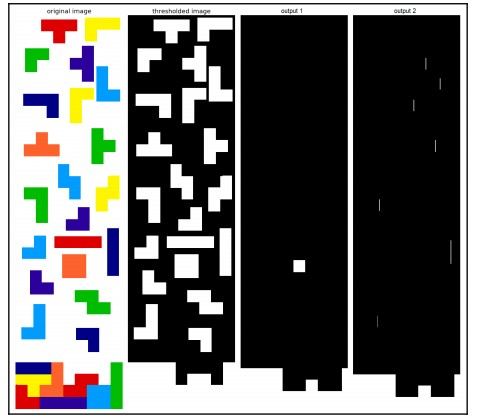

In [ ]:
# TO DO ... - uraditi zadatak

**Zadatak 1.**

Pomoću morfoloških operacija pronađite dijamante na fotografiji karte (images/card.png), kao što je prikazano na fotografiji u nastavku:

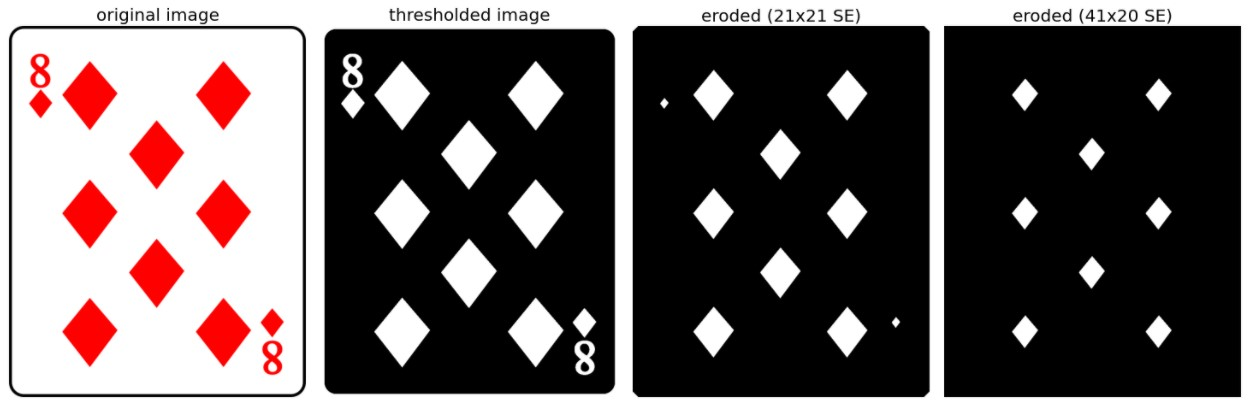

In [ ]:
# TO DO ... - uraditi zadatak